In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import sys
from jupyterthemes import jtplot

In [2]:
jtplot.style('default', grid=False)

# ALI depletion test for 100 pulses, 1 bar GAr
 - Goal: estimate $\delta V = V/N$: typical injected volume per pulse from the initially injected volume V and number of pulses N required to deplete it.

## Estimate maximum injected mass at the time for ~10 pulses, 1 bar GAr  

In [3]:
from ali.ali_sw import *

## Run 1
 - p$_{Ar}$ = 1000 mbar
 - t$_{on}$ = 70 ms
 - 100 pulses

In [4]:
df = load_raw_ali_df('../ali_data/18072019_ALI_Cleaning_200mbar_70ms_100pulses_rga')

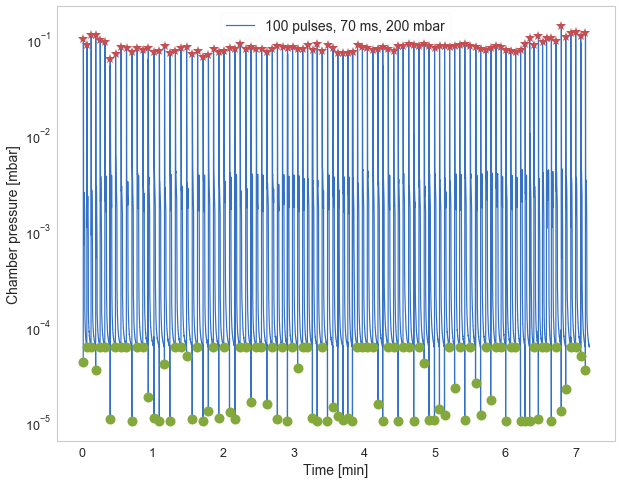

In [6]:
peaks, troughs = plot_pressure_curve(df, tit='100 pulses, 70 ms, 200 mbar')

In [7]:
df.p_chamber[troughs[7]-1+np.where(df.p_chamber[troughs[7]:peaks[7]] >= 2e-7)[0]]

2835    0.000061
2836    0.000061
2837    0.000061
2838    0.000063
2839    0.001365
2840    0.010143
2841    0.010335
2842    0.006002
2843    0.005946
2844    0.008025
2845    0.000158
2846    0.023138
2847    0.030649
2848    0.039845
2849    0.053778
2850    0.062477
Name: p_chamber, dtype: float64

In [63]:
troughs[7] += np.where(df.p_chamber[troughs[7]:peaks[7]] >= 2e-7)[0][0] - 1

In [67]:
troughs[7] -= 1

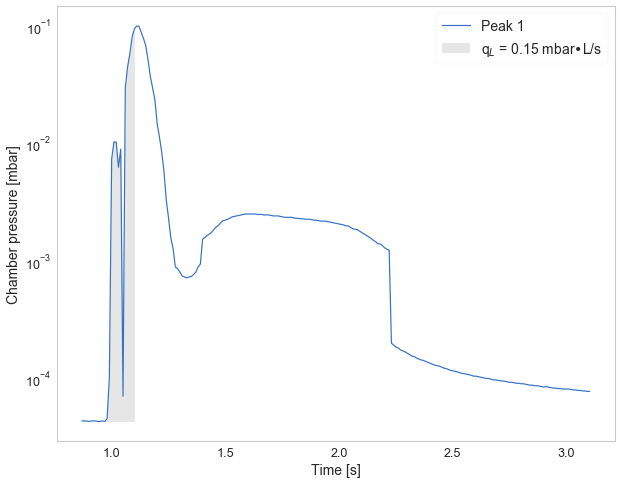

In [9]:
plot_pressure_curve(df[troughs[0]-10:peaks[0]+200], tit='Peak 1', scale='s', flag_p=False)

# plt.plot(troughs[0]*10, df.p_chamber[troughs[0]], 'o', markersize=10)
# plt.plot(peaks[0]*10, df.p_chamber[peaks[0]], 'o', markersize=10)
plt.xlabel('Time [s]', fontsize=14)
_,_, q,_ = leaked_mass(df, peaks, troughs, )

x=df.index[troughs[0] : peaks[0]]/100
plt.fill_between(x, df.p_chamber[troughs[0]], df.p_chamber[troughs[0]:peaks[0]],  color='0.9', label='q$_L$ = %.2f mbar•L/s'%q[0])
plt.legend(loc='best', fontsize=14)

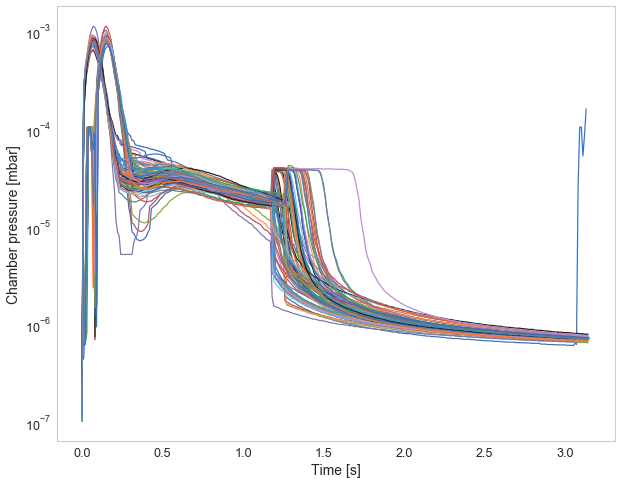

In [8]:
sc = 100
scale = 's'
xrange = 300
plt.figure(figsize=(10,8))

for i in range(len(peaks)-15):
    y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
    x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc
    
    plt.plot(x, y, '-', label='peak '+str(i));

    plt.xlabel('Time ['+scale+']', fontsize=14)
    plt.yscale('log')
    plt.ylabel('Chamber pressure [mbar]', fontsize=14)
#     plt.legend(loc='right',fontsize=4)

### Project peaks in 3d 

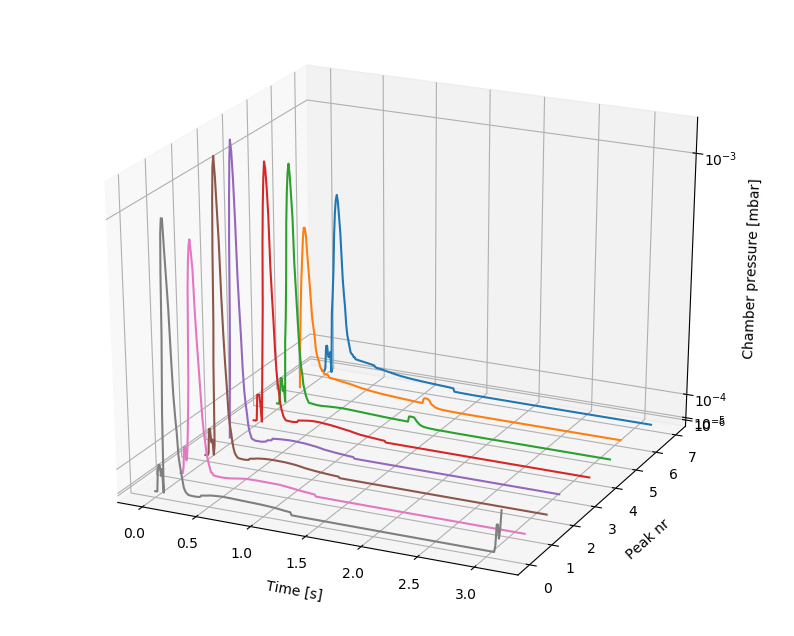

In [10]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

style.use('default')
sc = 100
scale = 's'
xrange = 300
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in range(7,-1,-1):
    y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
    x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc
    
    ax.plot(x, y, zs=i, zdir='y', label='peak '+str(i));

    ax.set_xlabel('\nTime ['+scale+']')#, linespacing=3)
    ax.set_zscale('log')
    ax.set_zlabel('\nChamber pressure [mbar]')
    ax.set_ylabel('\nPeak nr')

#     ax.legend(loc='right',fontsize=14)
ax.view_init(elev=25., azim=-65)
plt.savefig('overlap_peaks3d.png', dpi=100)
plt.show()

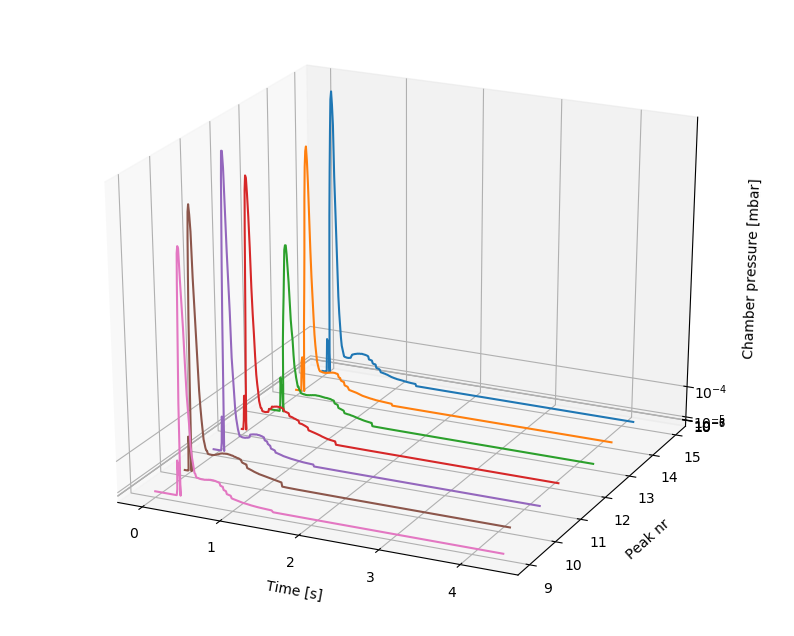

In [160]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style

style.use('default')
sc = 100
scale = 's'
xrange = 400
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in range(15,8,-1):
    y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
    x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc
    
    ax.plot(x, y, zs=i, zdir='y', label='peak '+str(i));

    ax.set_xlabel('\nTime ['+scale+']')#, linespacing=3)
    ax.set_zscale('log')
    ax.set_zlabel('\nChamber pressure [mbar]')
    ax.set_ylabel('\nPeak nr')

#     ax.legend(loc='right',fontsize=14)
ax.view_init(elev=25., azim=-65)
plt.savefig('overlap_peaks3d.png', dpi=100)
plt.show()

#####  Pumping speed for methanol
$$ S = A_P C' \sigma $$
$A_P$ : Aperture area
C' : conductance per surface area
$\sigma$ : capture probability

from https://indico.cern.ch/event/471931/contributions/1149644/attachments/1226014/1794773/JUAS_Vacuum_Technology.pdf slide 46

#####  Leak rate q$_L$
$$ q_L = S_{efec} \int_{t_1}^{t_1+\Delta t} P(t) \mathrm{d}t = \frac{\Delta(p \cdot V)}{\Delta t} = \frac{R\cdot T}{M} \cdot \frac{\Delta m}{\Delta t} $$

$S_{efec}$ : Effective pumping speed (L/s)

$R$ : Gas constant (83.144598 L⋅mbar/K⋅mol)

$M$ : Molar mass (32.041 g/mol for methanol)

$\Delta m$ : leaked mass (g)
From https://doi.org/10.1063/1.4964434

##### Leaked mass $\Delta m$
$$ \Delta m_{tot} = q_L \cdot \Delta t \frac{M}{RT} $$

In [101]:
delta_m, q, delta_t, error_delta_m = leaked_mass(df, peaks, troughs, M = 32.041, Seff=71)

delta_m

array([0.00393087, 0.00382445, 0.00369756, 0.00471314, 0.0044948 ,
       0.00577679, 0.00581936, 0.00459521, 0.00521024, 0.01243837,
       0.00538924, 0.00699725, 0.00378951, 0.00591965, 0.00669834,
       0.00619897, 0.00478574, 0.00454128, 0.00430216, 0.00434961,
       0.00452013, 0.00571956, 0.00610394, 0.00342581, 0.00492976,
       0.00597134, 0.00423518, 0.00555692, 0.00602884, 0.00559959])

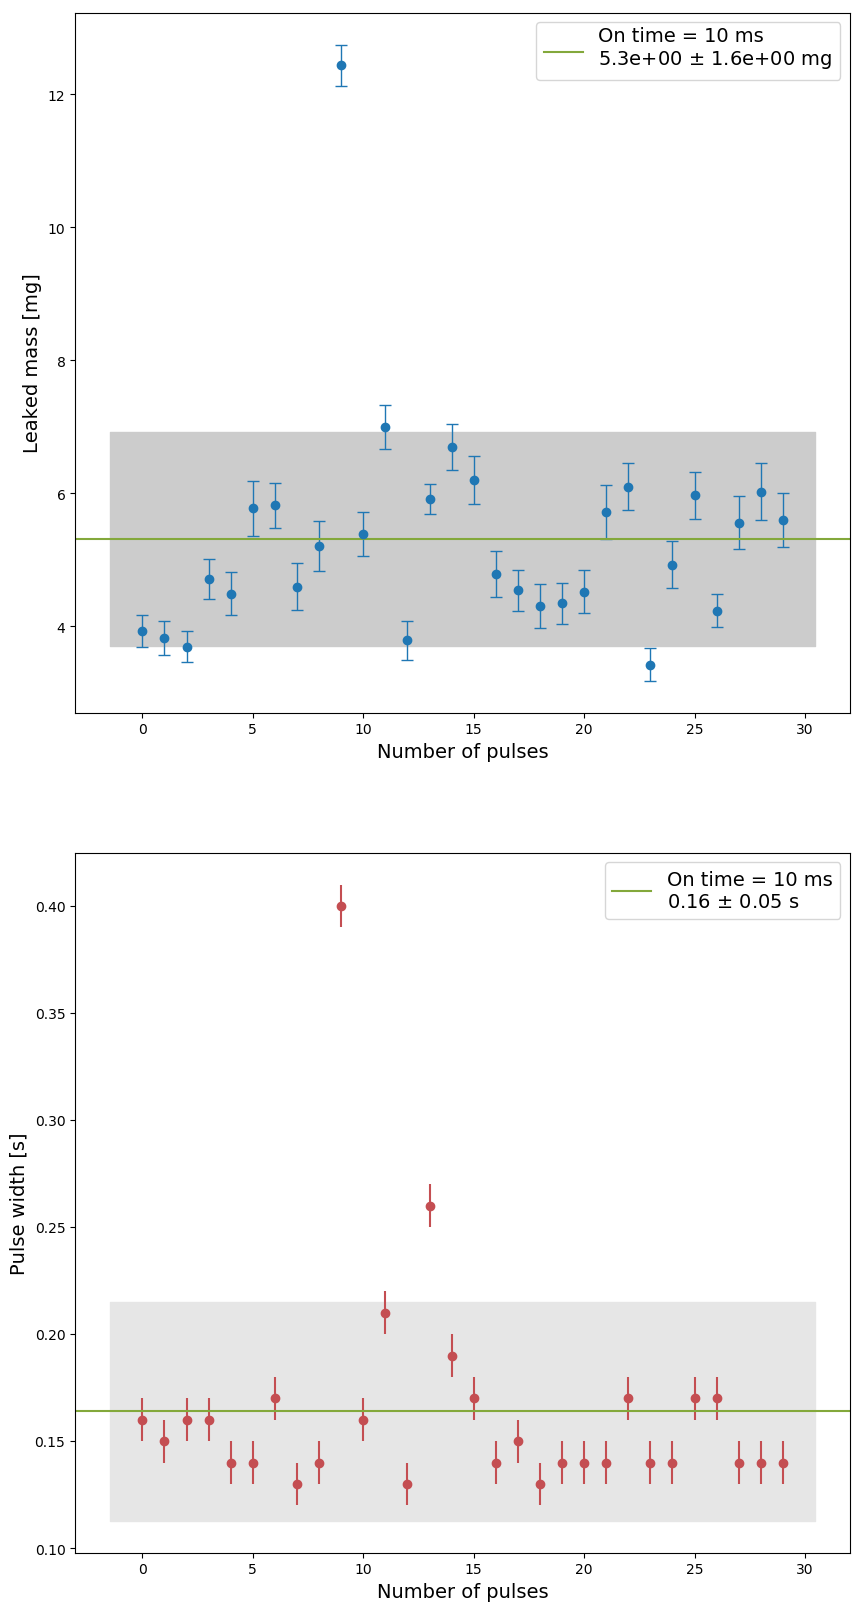

In [102]:
av_m, sd_m, _, _ = plot_leak_distributions(delta_m, error_delta_m, delta_t, label='10')

# Second run: 300 pulses

In [10]:
df1 = load_raw_ali_df('../ali_data/19072019_ALI_Cleaning_200mbar_70ms_300pulses_rga')

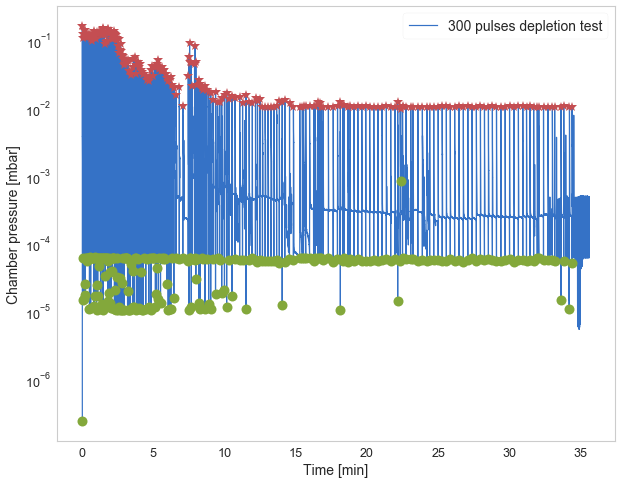

In [11]:
peaks1, troughs1 = plot_pressure_curve(df1, tit='300 pulses depletion test', th=0.05)

##### Compare the first and last peaks

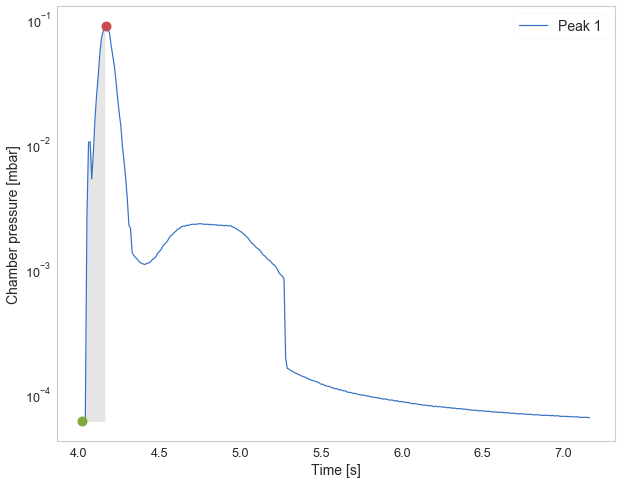

In [14]:
zoom_peak(1, df, peaks, troughs, xrange=300)

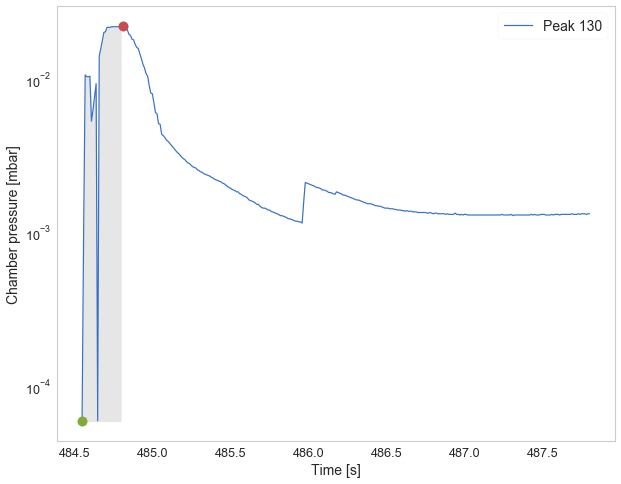

In [16]:
zoom_peak(130, df1, peaks1, troughs1, xrange=300)

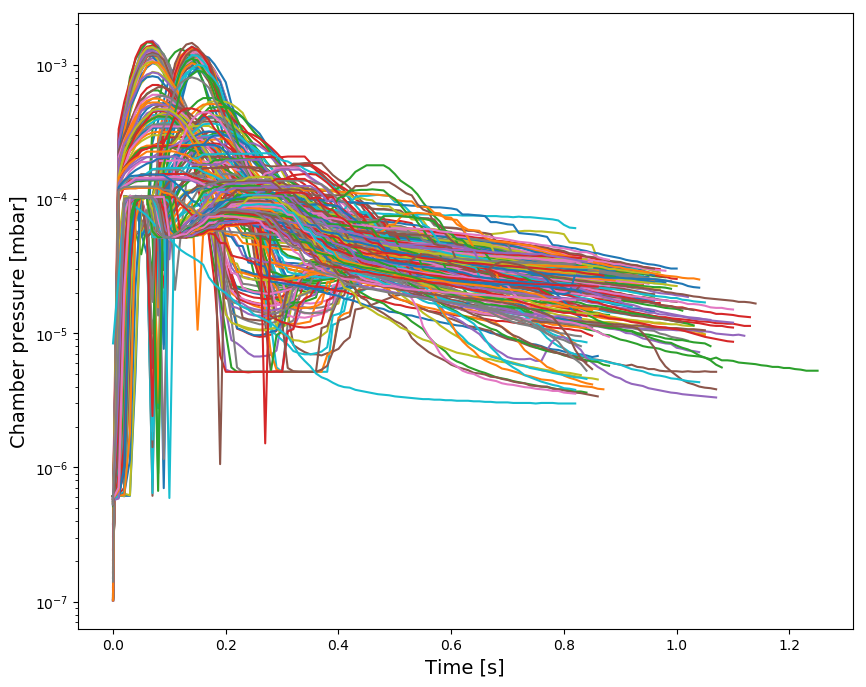

In [79]:
sc = 100
scale = 's'
xrange = 80
plt.figure(figsize=(10,8))

for i in range(1,len(peaks1)-15):
    y = df1.p_chamber[troughs1[i]:peaks1[i]+xrange]/sc
    x = df1.index[troughs1[i]:peaks1[i]+xrange]/sc - df1.index[troughs1[i]]/sc
    
    plt.plot(x, y, '-', label='peak '+str(i));

    plt.xlabel('Time ['+scale+']', fontsize=14)
    plt.yscale('log')
    plt.ylabel('Chamber pressure [mbar]', fontsize=14)
#     plt.legend(loc='right',fontsize=4)

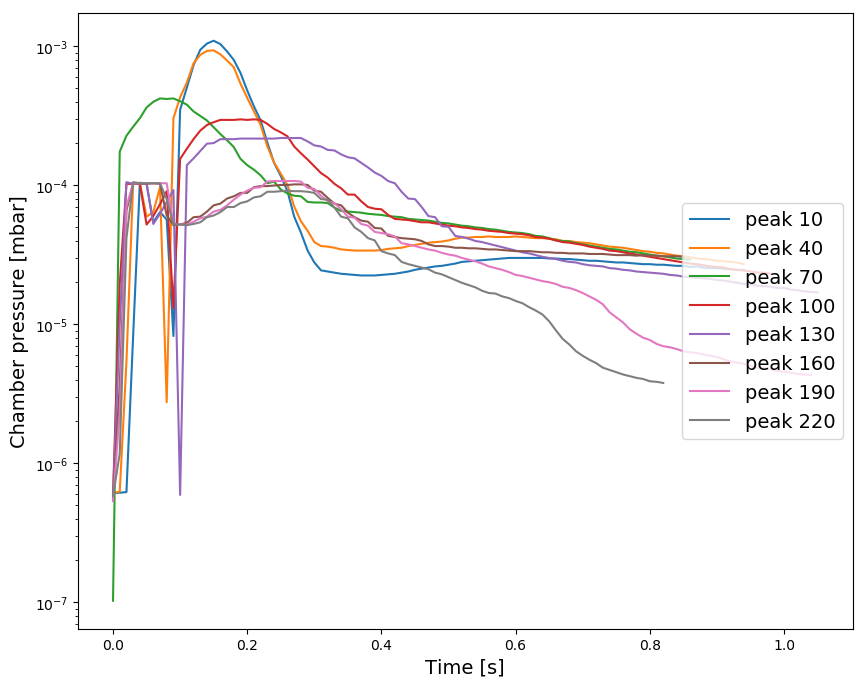

In [94]:
sc = 100
scale = 's'
xrange = 80
plt.figure(figsize=(10,8))

for i in np.arange(10,240, 30):
    y = df1.p_chamber[troughs1[i]:peaks1[i]+xrange]/sc
    x = df1.index[troughs1[i]:peaks1[i]+xrange]/sc - df1.index[troughs1[i]]/sc
    
    plt.plot(x, y, '-', label='peak '+str(i));

    plt.xlabel('Time ['+scale+']', fontsize=14)
    plt.yscale('log')
    plt.ylabel('Chamber pressure [mbar]', fontsize=14)
    plt.legend(loc='right',fontsize=14)

# xline = x[np.where(y, y > 9e-5, y < 2e-4)]
# plt.fill_betweenx(y, xline[0], xline[-1], color='g')

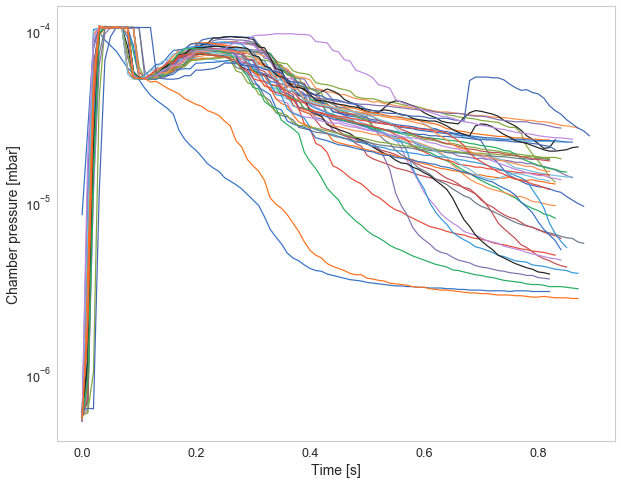

In [11]:
sc = 100
scale = 's'
xrange = 80
plt.figure(figsize=(10,8))

for i in range(200, 240):
    y = df1.p_chamber[troughs1[i]:peaks1[i]+xrange]/sc
    x = df1.index[troughs1[i]:peaks1[i]+xrange]/sc - df1.index[troughs1[i]]/sc
    
    plt.plot(x, y, '-', label='peak '+str(i));

    plt.xlabel('Time ['+scale+']', fontsize=14)
    plt.yscale('log')
    plt.ylabel('Chamber pressure [mbar]', fontsize=14)
#     plt.legend(loc='right',fontsize=4)

# xline = x[np.where(y, y > 9e-5, y < 2e-4)]
# plt.fill_betweenx(y, xline[0], xline[-1], color='g')

In [27]:
np.where((y > 9.9e-7) & (y < 1.1e-6), x, y)
y[(y > 9.7e-6) & (y < 1.2e-5)]

199049    0.000011
Name: p_chamber, dtype: float64

[18.0814124072459,
 13.078307096382206,
 0.13307377049180327,
 0.10897425384253609]

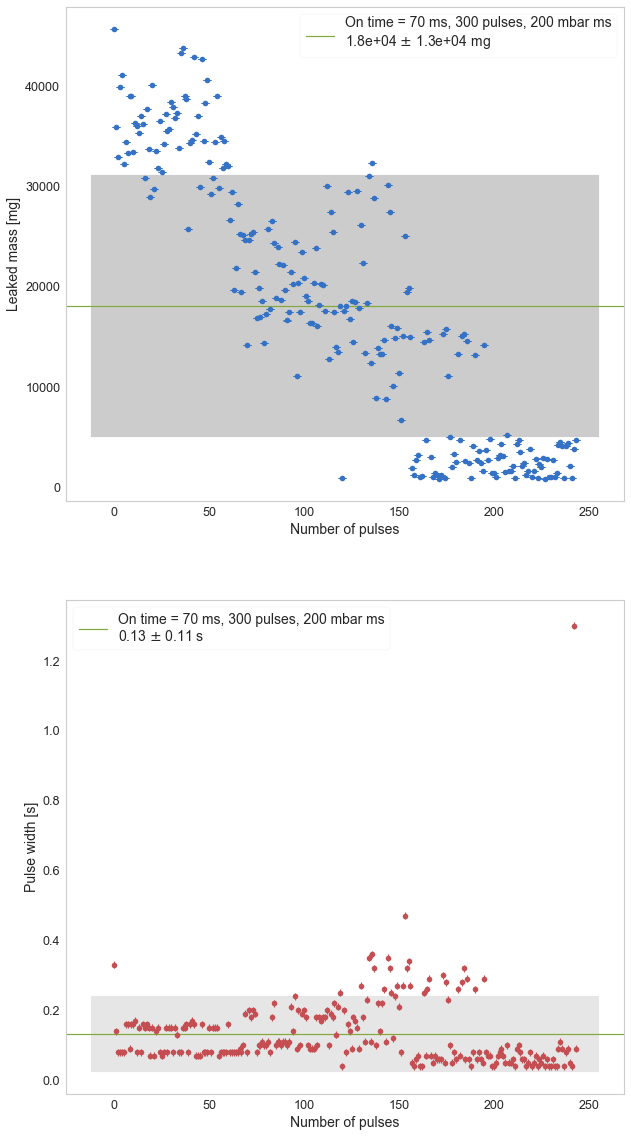

In [178]:
delta_m, q, delta_t, error_delta_m = leaked_mass(df1, peaks1, troughs1, M = 41)
plot_leak_distributions(q, error_delta_m, delta_t, label = '70 ms, 300 pulses, 200 mbar')

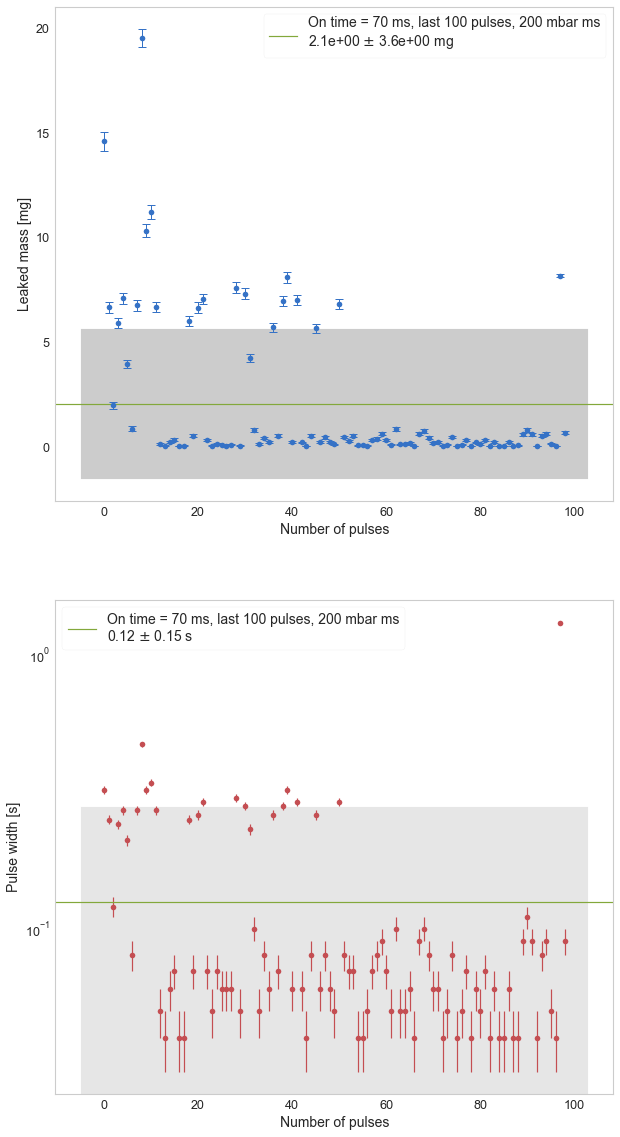

In [34]:
# delta_m, q, delta_t, error_delta_m = leaked_mass(df1, peaks1, troughs1, M = 41)
plot_leak_distributions(delta_m[145:], error_delta_m[145:], delta_t[145:], label = '70 ms, last 100 pulses, 200 mbar')
plt.yscale('log')

##### As we can see, from pulse 150 onwards, both the injected mass and the pulse width systematically drop

In [27]:
av_m = np.average(delta_m)
sd_m = np.std(delta_m)
av_m, sd_m, av_m-sd_m

(0.004487766361887604, 0.004126301591778426, 0.0003614647701091775)

In [43]:
# av_m150 = np.average(delta_m[])
len(delta_m[145:][delta_m[145:] > np.average(delta_m[145:])])
# np.average(delta_m[145:])


23

### How long does the solution last?

In [54]:
V_stock = 0.30 # mL through syringe
dV_stock = 0.01
N = 400-150
dN = 23 # Error estimated from the number of points above the systematic drop starting from pulse 150
V_inj = V_stock/N
dV_inj = V_inj*np.sqrt( (dV_stock/V_stock)**2 + (dN/N)**2)
V_inj, dV_inj

(0.0012, 0.00011742299604421613)

### Cross check with leaked mass calculation

In [55]:
rho_solv = 786 # g/L
M = 41 # g/mol
av_v = av_m*rho_solv
dav_v = av_n/av_m*sd_m
av_v, dav_v

(3.5273843604436568, 0.07910422075945958)

##### Okay so the leaked mass calculation is damn wrong, good to know

### Estimate solute molecules injected
We assume that the initial concentration was 1 mM (we performed a 10-pulse deposition before so it is not exactly correct)

Then, the initial number of solute molecules was 

$$N_i = V_{\mathrm{stock}} \times C = 0.3 \mathrm{mL} \times 10^{-3} \mathrm{mol}/L = 3\times10^{-7} \mathrm{mol} $$

### Estimate FBI molecular area

In [64]:
from dataclasses import dataclass
@dataclass
class Molecule:
    """Molecule to estimate molecular volume
    p : density (in g/cm3)
    M : molar mass (in g/mol)
    V : molecular volume (estimate, in cm3)"""
    name : str
    p : float
    M : float
    def volume(self)->float:
        Na = 6.022e23
        return self.M/self.p/Na

In [76]:
crw_eth = Molecule('18-Crown-6', p = 1.237, M = 264.315)
crw_eth.volume()
print('Estimated crown ether volume: {0:5.1e} cm3'.format(crw_eth.volume()))
print('Molecule size (order of magn.): {0:5.1e} cm = {1:5.1e} nm'.format(crw_eth.volume()**(1/3), crw_eth.volume()**(1/3)/1e-7))

Estimated crown ether volume: 3.5e-22 cm3
Molecule size (order of magn.): 7.1e-08 cm = 7.1e-01 nm


In [80]:
Pentane = Molecule('Pentane', M = 70.1, p = 0.751)
Pentane.volume()
print('Estimated Pentane volume: {0:5.1e} cm3'.format(Pentane.volume()))
print('Molecule size (order of magn.): {0:5.1e} cm = {1:5.1e} nm'.format(Pentane.volume()**(1/3), Pentane.volume()**(1/3)/1e-7))

Estimated Pentane volume: 1.6e-22 cm3
Molecule size (order of magn.): 5.4e-08 cm = 5.4e-01 nm


In [81]:
Benzene = Molecule('Benzene', M = 78.114, p = 0.8765)
Benzene.volume()
print('Estimated Benzene volume: {0:5.1e} cm3'.format(Benzene.volume()))
print('Molecule size (order of magn.): {0:5.1e} cm = {1:5.1e} nm'.format(Benzene.volume()**(1/3), Benzene.volume()**(1/3)/1e-7))

Estimated Benzene volume: 1.5e-22 cm3
Molecule size (order of magn.): 5.3e-08 cm = 5.3e-01 nm


In [111]:
V_FBI = crw_eth.volume() + 3 * Benzene.volume() + 2 * Pentane.volume()
print('Estimated FBI volume: {0:5.1e} cm3'.format(V_FBI))
print('Molecular area (order of magn.): {0:5.2e} cm2 = {1:5.1e} nm2'.format(V_FBI**(2/3), V_FBI**(2/3)/1e-14))

Estimated FBI volume: 1.1e-21 cm3
Molecular area (order of magn.): 1.07e-14 cm2 = 1.1e+00 nm2


### Estimate number of molecules in a ML on a 1cm$^2$ substrate

In [91]:
from invisible_cities.core.system_of_units import cm2
area_molec = 3.33e-11
area_substr = 1 * cm2
Na = 6.022e23
N_ML = area_substr/area_molec/Na
N_ML

4.986720363671543e-12

### So from V$_{inj}$ we can estimate the needed concentration if the whole deposition was one pulse and all the spray landed on the substrate

In [113]:
V_inj # mL

0.0012

In [191]:
print('C = {0:5.2e} mol/mL = {1:5.2e} µmol/L'.format(N_ML/V_inj * 1e3, N_ML/V_inj * 1e9))

C = 4.16e-06 mol/mL = 4.16e+00 µmol/L


### Assume a conic spray [...]

# Run 3 (reload Vstock, t$_{on}$ = 50 ms) 

 - V$_{stock}$ = 0.3 mL
 - p$_{Ar}$ = 1000 mbar
 - t$_{on}$ = 50 ms
 - 100 pulses

In [114]:
df2 = load_raw_ali_df('../ali_data/26072019_Depletion_200mbar_50ms_350pulses_rga')

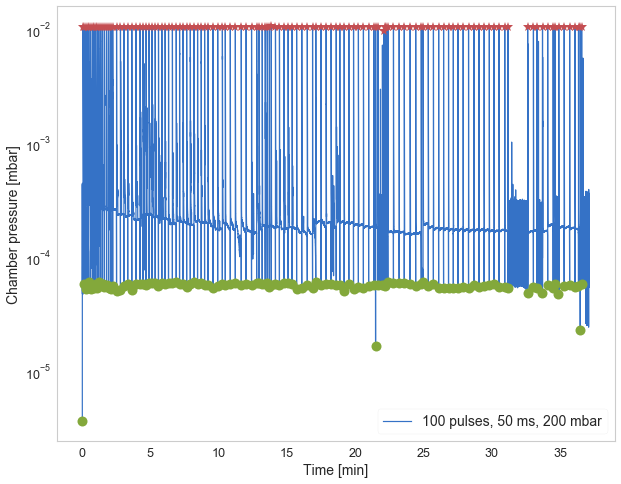

In [129]:
peaks2, troughs2 = plot_pressure_curve(df2, tit='100 pulses, 50 ms, 200 mbar', th=0.9)

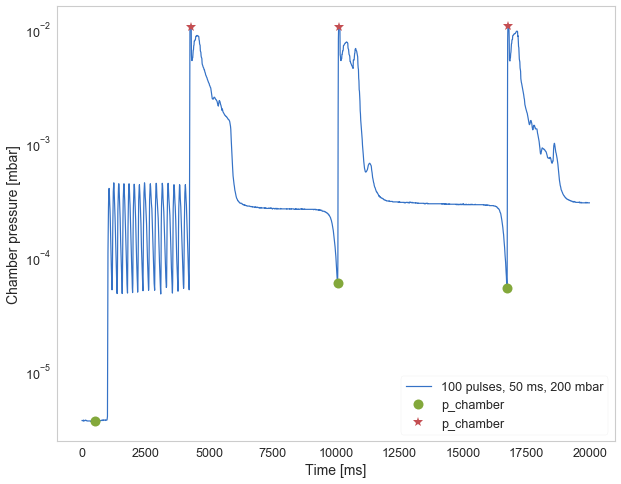

In [181]:
plot_pressure_curve(df2[:2000], tit='100 pulses, 50 ms, 200 mbar', th = 0.9, scale='ms')
von = df2.index[(df2.valve == 1) & (df2.index < 2000)]
# plt.plot(von/100/60, df2.p_chamber[von], 'sk', label='Valve == True')
plt.legend()

In [133]:
len(peaks2)

127

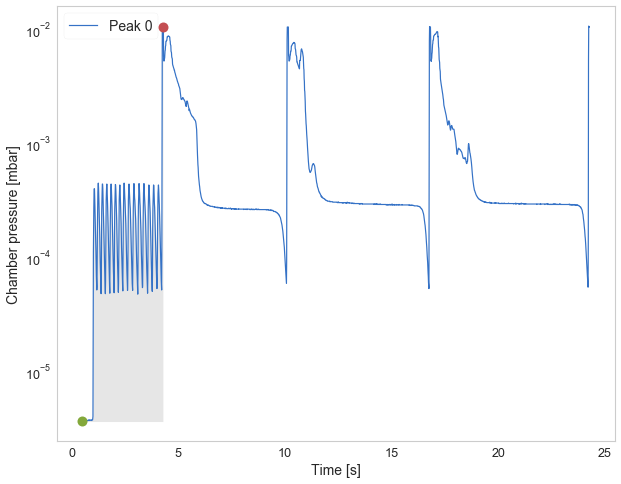

In [117]:
zoom_peak(0, df2, peaks2, troughs2, xrange=2000)

zoom_peak(126, df2, peaks2, troughs2, xrange=3000)

### Another way to find out the total Npeaks is through the data parameters "valve" [on/off]
Since logtime = 10 ms and t_on = 50 ms, for each peak there should be 5 points for which df2.valve == 1:

In [162]:
df2.index[df2.valve == 1]

Int64Index([    98,     99,    100,    101,    102,    117,    118,    119,
               120,    121,
            ...
            222752, 222753, 222754, 222755, 222756, 222773, 222774, 222775,
            222776, 222777],
           dtype='int64', length=1721)

In [125]:
len(df2.valve[df2.valve == 1])/5

344.2

## Compare to solvent only shape 

In [164]:
dfsolv = load_raw_ali_df(f'../ali_data/Acetonitrile/200mbar/10072019_Acetonitrile_200mbar_50ms_DwellTime2ms_10pulses_rga')

[array([ 103,  969, 1886, 2738, 3600, 4541, 5536, 6613, 7502, 8480]),
 array([  97,  961, 1877, 2728, 3591, 4533, 5529, 6605, 7491, 8472])]

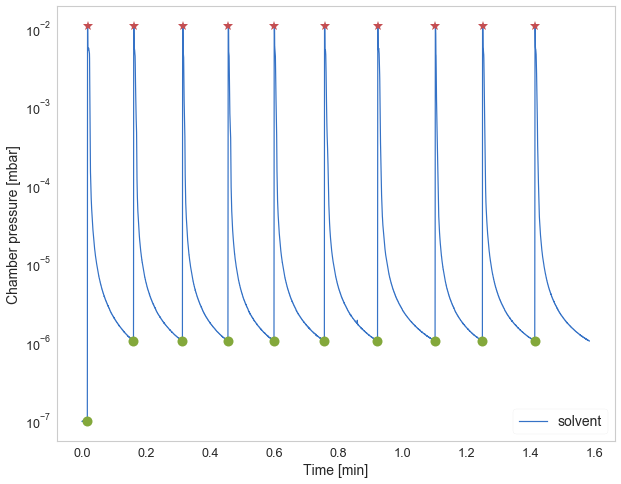

In [165]:
plot_pressure_curve(dfsolv, tit = 'solvent')

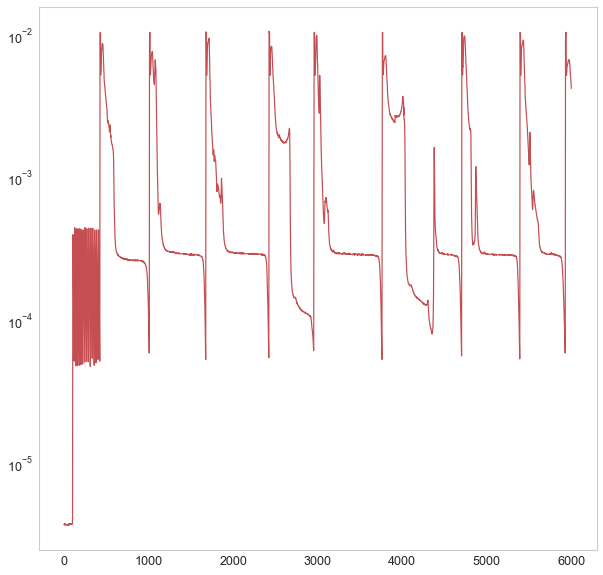

In [177]:
xs = dfsolv.index.values
ys = dfsolv.p_chamber.values

xm = df2.index.values[:6000]
ym = df2.p_chamber[:6000].values

plt.figure(figsize=(10,10))
# plt.plot(xs, ys, '-b', label='Solvent curve')
plt.plot(xm, ym, '-r', label='Molecule curve')
plt.yscale('log')

In [175]:
df2.p_chamber[troughs2]/1e-4

49        0.03623
1007      0.58583
1675      0.52845
2421      0.54352
2951      0.60821
3759      0.52845
4701      0.55902
5389      0.53343
5926      0.58583
6712      0.53845
7333      0.60821
8187      0.57495
8978      0.58037
9839      0.54352
10763     0.57495
11678     0.53343
12658     0.52845
13453     0.55380
15135     0.50901
16846     0.51380
18366     0.55380
20047     0.58037
21840     0.51864
23662     0.58037
25472     0.58037
26766     0.58583
28115     0.57495
29413     0.59135
30698     0.59692
32103     0.59135
           ...   
154305    0.58037
156601    0.53343
158766    0.53845
160941    0.53845
163042    0.53343
165108    0.53845
167366    0.54352
169727    0.53343
172083    0.57495
174291    0.54864
176572    0.55380
178850    0.57495
180929    0.58037
183117    0.54864
185634    0.54864
187075    0.53343
195637    0.48571
198226    0.54352
199763    0.53343
201846    0.48118
204496    0.56428
206892    0.53845
207715    0.58037
209126    0.47225
211730    

In [172]:
ym[1000:2000]

array([1.0088400e-04, 9.2725000e-05, 8.5225000e-05, 7.9069000e-05,
       7.3358000e-05, 6.4944000e-05, 5.9692000e-05, 5.8583000e-05,
       9.1003000e-05, 1.7257580e-03, 8.0247430e-03, 1.0335141e-02,
       1.0335141e-02, 1.0335141e-02, 1.0335141e-02, 1.0335141e-02,
       1.0335141e-02, 5.8352190e-03, 5.6734560e-03, 5.2145790e-03,
       5.2145790e-03, 5.2145790e-03, 5.4137540e-03, 5.4137540e-03,
       5.8901580e-03, 5.8901580e-03, 6.1727130e-03, 6.3487110e-03,
       6.3487110e-03, 6.4688220e-03, 7.0380710e-03, 7.0380710e-03,
       7.1043350e-03, 7.1712240e-03, 7.2387420e-03, 7.3068960e-03,
       7.3756910e-03, 7.3756910e-03, 7.4451350e-03, 7.4451350e-03,
       7.5152320e-03, 7.5152320e-03, 7.5859890e-03, 7.5152320e-03,
       7.5152320e-03, 7.5152320e-03, 7.4451350e-03, 7.3756910e-03,
       6.7159040e-03, 6.5912050e-03, 6.5297270e-03, 6.1151380e-03,
       5.8901580e-03, 5.8352190e-03, 5.7807910e-03, 5.6205370e-03,
       5.1177560e-03, 5.1177560e-03, 5.0227310e-03, 4.9294710e

## Crosscheck with RGA

In [163]:
from rga.rga_sw import *

In [180]:
load_mid_data(f'../rga_data/20190726_173455_Faraday_FBI_depletion_run2_1mM_50ms_200mbar_mid.asc')

ValueError: Length mismatch: Expected axis has 57 elements, new values have 33 elements

In [17]:
M = 41
av_ntot = av_m/M
sd_ntot = sd_m/M

V_inj = 0.3 # mL

NameError: name 'av_m' is not defined

## Run 2: fluorescein
 - p$_{Ar}$ = 1000 mbar
 - t$_{on}$ = 10 ms
 - 10 pulses

In [4]:
df2 = load_raw_ali_df('../sabatsw/ali/ali_data/22032019_fluorescein_1000mbar_10ms_10pulses_au')
peaks_and_troughs(df2.p_chamber)

(array([   111,  45638, 150217, 258075, 309687, 358980, 420701, 475352,
        541494]),
 array([    99,  45626, 150202, 258062, 309670, 358967, 420683, 475337,
        541479]))

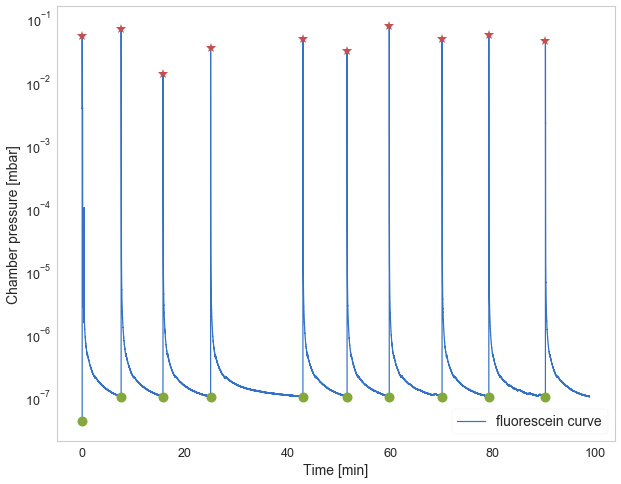

In [5]:
pflu, tflu = plot_pressure_curve(df2, tit='fluorescein curve')

In [11]:
def overlay_peaks(df: pd.DataFrame, peaks: np.array, troughs: np.array, 
                  npulses : int, xrange : int = 900, scale: str = 's'):
    """Shift and overlap pulses to check reproducibility.
    Params
    ----------
    npulses : int
        Number of pulses to show
    xrange: int
        pulse duration in entries. Default 900 = 9 s
    scale: str
        time scale, accepts: 'ms' and (default) 's'
    """
    if scale == 'ms':
        sc = 1
    else:
        sc = 100
    plt.figure(figsize=(10,8))

    for i in range(npulses):
        y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
        x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc

        plt.plot(x, y, '-', label='peak '+str(i));

        plt.xlabel('Time ['+scale+']', fontsize=14)
        plt.yscale('log')
        plt.ylabel('Chamber pressure [mbar]', fontsize=14)
        plt.legend(loc='right',fontsize=14)

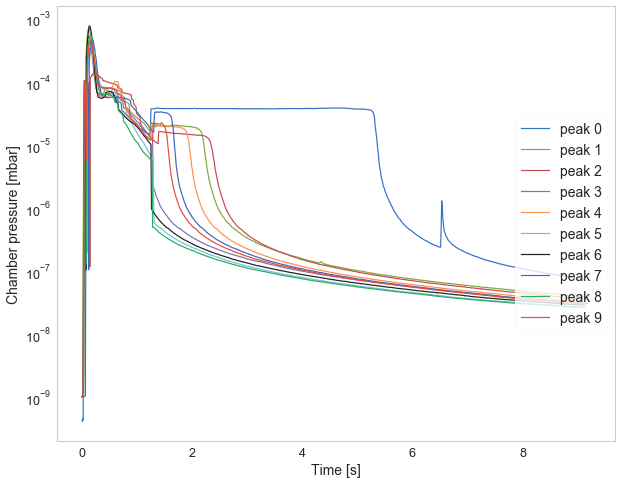

In [23]:
overlay_peaks(df2, pflu, tflu, 10)

In [33]:
from mpl_toolkits.mplot3d import Axes3D
def plot3d_pulses(df : pd.DataFrame, peaks: np.array, troughs: np.array,
                  npulses: int,
                  xrange: int = 400, scale: str = 's'):
    """Shift and 3d-plot npulses"""

    if scale == 'ms':
        sc = 1
    else:       
        sc = 100
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')

    for i in range(npulses-1,-1,-1):
        y = df.p_chamber[troughs[i]:peaks[i]+xrange]/sc
        x = df.index[troughs[i]:peaks[i]+xrange]/sc - df.index[troughs[i]]/sc

        ax.plot(x, y, zs=i, zdir='y', label='peak '+str(i));

        ax.set_xlabel('\nTime ['+scale+']')#, linespacing=3)
        ax.set_zscale('log')
        ax.set_zlabel('\nChamber pressure [mbar]')
        ax.set_ylabel('\nPeak nr')

    #     ax.legend(loc='right',fontsize=14)
    ax.view_init(elev=25., azim=-65)
    plt.show()

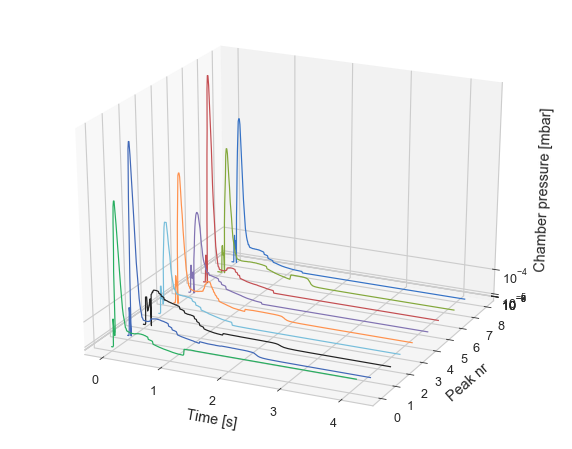

In [34]:
plot3d_pulses(df2, pflu, tflu, 9)

In [27]:
def zoom_peak(peak_id : int, 
             df : pd.DataFrame,
             peaks : np.array, troughs : np.array,
             xrange : int = 900):
    """Use plot_pressure_curve focused on a specific peak index (peak_id) 
    and specify time range (default 900 s)"""
    plot_pressure_curve(df[troughs[peak_id]:peaks[peak_id]+xrange], tit='Peak '+str(peak_id), scale='s', flag_p=False)
    plt.plot(troughs[peak_id]/100, df.p_chamber[troughs[peak_id]], 'o', markersize=10)
    plt.plot(peaks[peak_id]/100, df.p_chamber[peaks[peak_id]], 'o', markersize=10)
    
    x=df.index[troughs[peak_id] : peaks[peak_id]]/100
    plt.fill_between(x, df.p_chamber[troughs[peak_id]], df.p_chamber[troughs[peak_id]:peaks[peak_id]],  color='0.9')#, label='q$_L$ = %.2f mbar•L/s'%q[peak_id])
    

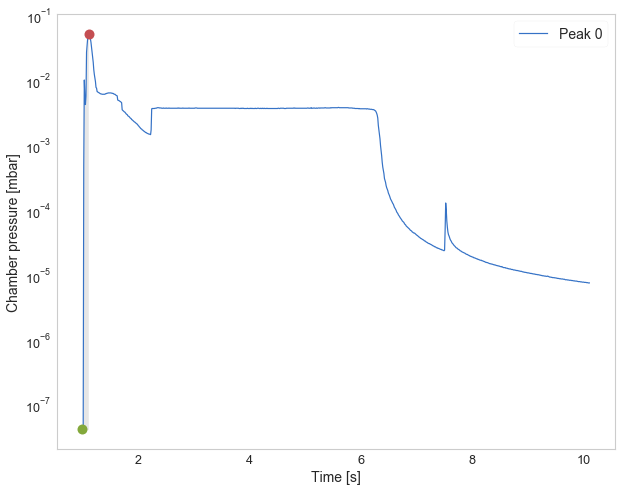

In [28]:
zoom_peak(0, df2, pflu, tflu)

In [81]:
delta_m, q, delta_t, error_delta_m = leaked_mass(df2, pflu, tflu, M = 32.041)

delta_m

array([0.00258526, 0.00350586, 0.00342066, 0.00289294, 0.0029112 ,
       0.00353925, 0.00395316, 0.0038422 , 0.00414747, 0.00339714])

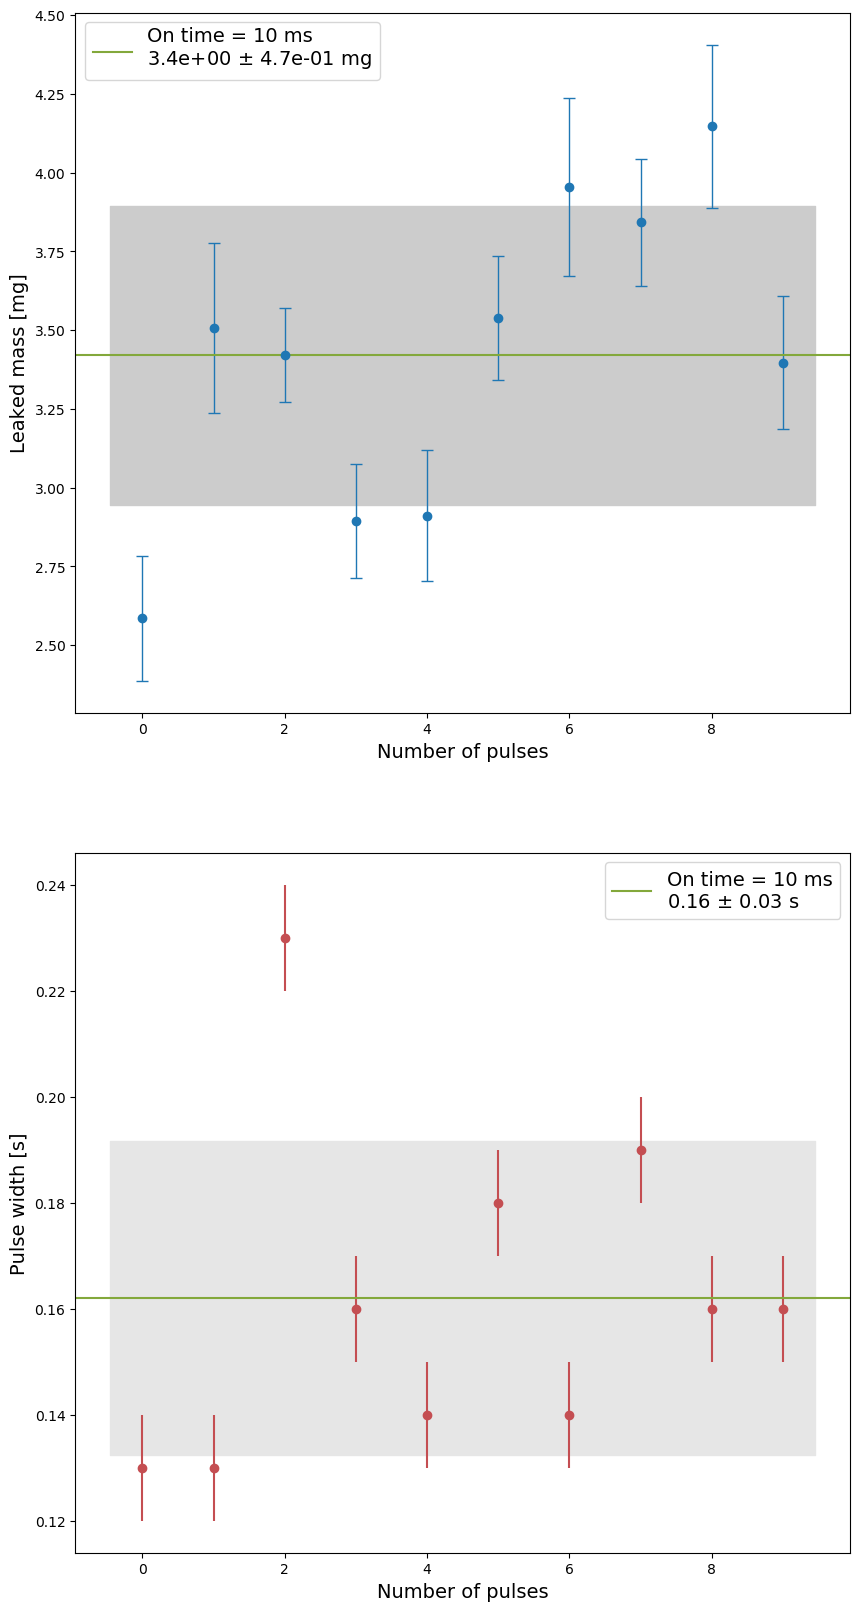

In [83]:
av_m, sd_m, _, _ = plot_leak_distributions(delta_m, error_delta_m, delta_t, label='10')

### Estimate fluorescein (solute) mass injection
$$ q_L = R T \frac{\Delta n_{tot}}{\Delta t} $$

$$ \Delta n_{tot} = \frac{q_L\cdot \Delta t}{RT} = \Delta n_{meth} + \Delta n_{fluo} = \Delta n_{fluo} \left(1+\frac{\Delta V_{meth}\cdot\rho_{meth}/M_{meth}}{\Delta n_{fluo}}\right) = \Delta n_{fluo} \left(1 + \frac{\rho_{meth}}{C\cdot M_{meth}}\right) $$

$C$ : solution concentration = 0.5 mmol/L

$M_{meth}$ : methanol molar mass = 32.041 g/mol

$\rho_{meth}$ : mass density = 792 g/L

$$ \Delta n_{fluo} = \frac{q_L\cdot \Delta t}{RT \left(1+\frac{\rho_{meth}}{C M_{meth}}\right)} $$

In [105]:
def nsolute(q : np.array, delta_t : np.array, df:pd.DataFrame, rho : float = 792.0, M : float = 32.041, C : float = 0.5):
    logtime = (df.datetime[1]-df.datetime[0]).total_seconds() # [10 ms]
    T = df.t_valve[0]+273 # Pulse valve temperature [K]
    R = 83.144598
    
    ntot = q*delta_t/(R*T)
    av_tot = np.average(ntot)
    sd_tot = np.std(ntot)
    
    nsol = q*delta_t/(R*T * (1 + rho/(C * M)))
    av_nsol = np.average(nsol)
    sd_nsol = np.std(nsol)
    
    return [av_nsol, sd_nsol, av_ntot, sd_ntot]

In [109]:
av_nfluo, sd_nfluo, av_ntot, sd_ntot = nsolute(q, delta_t, df)
print ('%.2e +-%.2e mol' %(av_nfluo, sd_nfluo))

3.29e-06 +-9.98e-07 mol


In [110]:
M_fluo = 331.3 #g/mol
print('%.2e +- %.2e g'%(av_nfluo*M_fluo, sd_nfluo*M_fluo))

1.09e-03 +- 3.30e-04 g


#####  From here we estimate the mole fractions:
$$ x_{fluo} = \frac{n_{fluo}}{n_{tot}} \qquad x_{meth} = 1-x_{fluo}$$

In [116]:
x_fluo = av_nfluo/av_ntot
x_fluo, 1-x_fluo

(0.01982684845248357, 0.9801731515475164)

##### Compute average density and molar mass
$$ \bar{M} = \sum_i x_i M_i \qquad  \bar{\rho} = \sum_i x_i \rho_i$$

$$ n_{batch} = \frac{\bar{\rho}}{\bar{M}} V_{batch} $$

In [120]:
M_meth = 32.041 # g/mol
rho_meth = 792.0 # g/L
rho_fluo = 1602.0 # g/L
M_mix = x_fluo*M_fluo + (1-x_fluo)*M_meth
rho_mix = x_fluo*rho_fluo + (1-x_fluo)*rho_fluo

V_batch = 0.3e-3 # L
n_batch = rho_mix/M_mix * V_batch
n_batch

0.012655906881486344

#####  Then the minimum number of pulses we need to deplete the batch is
$$ N_{pulses}^{(min)} = \frac{n_{batch}}{n_{pulse}} $$

In [121]:
n_batch/av_ntot

76.24066687482524

In [124]:
av_ntot

0.00016599942524460446

# Result

In [125]:
print("Typical leak mass: %.1e +- %.1e g" %(av_m, sd_m))

Typical leak mass: 5.3e-03 +- 1.6e-03 g


In [52]:
av_m/0.166155*1e3

0.257394611551979

## Other stuff: pumping speed
First approx. (no vapor pressure taken into account)

In [107]:
len(np.where(df2.valve.values != 0)[0])

10

In [50]:
avg/1e-3, sd*1e3, np.average(error_delta_m)*1e3

(0.026358223836644674, 0.00403068162584347, 0.0017622614319262179)

#####  Argon pumping speed
$Q_P = \frac{1}{4}A_Pn<v>\sigma$ = 0.54 mbar•l/s

$S_{eff}$ = 66 l/s

$S = Q_P/P = A_P C' \sigma$

$C' (273K) = \frac{1}{4} <v> = 9.85 $ l/(s•cm$^2$)

$A_P$ (CF 40) = 62.3 cm$^2$

##### Assuming $\sigma$ = 1, i.e. total capture probability:

In [35]:
A = np.pi/4*63**2/100 # DN 63 mm^2 -> cm^2
v = 4*9.85
C = v/4
S = A*C
S, v

(307.0486630866605, 39.4)

#####  Which agrees with the result in 
https://indico.cern.ch/event/471931/contributions/1149644/attachments/1226014/1794773/JUAS_Vacuum_Technology.pdf slide 47
From this we can conclude that $S_{eff} \neq  S$ and we can estimate $\sigma = S_{eff}/S = 0.21$ 

In [42]:
Seff = 66
sigma = Seff/S
sigma

0.21494964132565644

#####  This probability does not have to coincide with that of methanol, but we will assume it does for the moment

In [38]:
R = 83.144598
M = 32.041
T = 273

v_meth = np.sqrt(8*R*T/(np.pi*M))
v_meth

42.47323774458813

In [44]:
S_meth = A*v_meth/4
Seff_meth = S_meth*sigma
S_meth, Seff_meth

(330.9987529552709, 71.14806322697504)

##### This should make sense keeping in mind that the molecular mass of methanol is lighter than that of Argon

However this assumes, as said, that the methanol behaves immediately as an ideal gas following the Boltzmann distribution for thermal velocity and that the capture rate is the same as for Argon, which I doubt, methanol should be more reactive